In [12]:
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from alibi.datasets import fetch_adult
from alibi.explainers import CounterFactualProto
import pandas as pd 
import tensorflow as tf
from alibi.explainers import CounterFactual
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from ceteris_paribus.profiles import individual_variable_profile
from ceteris_paribus.plots.plots import plot_notebook, plot
from ceteris_paribus.explainer import explain
import imgkit
import shutil
import base64
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import table
from sklearn.tree import DecisionTreeClassifier
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [42]:
data = pd.read_csv('titanic.csv')
data.rename(columns={'Survived': 'class'}, inplace=True)
data['Sex'] = data['Sex'].map({'male':'Male','female':'Female'})
data['Embarked'] = data['Embarked'].map({'S':'Southampton','C':'Cherbourg','Q':'Queenstown'})
data['Pclass'] = data['Pclass'].map({1:'First', 2:'Second', 3:'Third'})
data['Relatives'] = data['SibSp'] + data['Parch']

data = data.drop(['PassengerId', 'Name','Ticket','Cabin', 'SibSp', 'Parch'], axis=1)
data = data.dropna()

f = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Relatives']

features = data.drop('class', axis=1)
#print(features)

training_features, testing_features, training_target, testing_target = \
    train_test_split(features, data['class'].values, random_state=None)

In [43]:
numeric_features = ['Age', 'Fare', 'Relatives']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [44]:
model = Pipeline(steps=[('preprocessor', preprocessor),
('classifier', XGBClassifier())])

In [45]:
model.fit(training_features, training_target)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   MinMaxScaler(copy=True,
                                                                                feature_range=(0,
                                                                                               1)))],
                                                           verbose=False),
                                                  ['Age', 'Fare', 'Relatives']),
                                                 ('cat',
                                                  P

In [46]:
print("XGB {}".format(accuracy_score(testing_target, model.predict(testing_features))))

XGB 0.8314606741573034


In [47]:
def adapter(x):
    d = pd.DataFrame(data=x, columns = f)
    d['Sex'] = d['Sex'].map({0:'Male', 1: 'Female'})
    d['Embarked'] = d['Embarked'].map({0: 'Southampton', 1: 'Cherbourg', 2: 'Queenstown'})
    d['Pclass'] = d['Pclass'].map({0: 'First', 1: 'Second', 2: 'Third'})
    return d

In [59]:
def reverse_adapter(p):
    d = p.copy()
    d['Sex'] = d['Sex'].map({'Male': 0, 'Female': 1})
    d['Embarked'] = d['Embarked'].map({'Southampton': 0, 'Cherbourg': 1, 'Queenstown': 2})
    d['Pclass'] = d['Pclass'].map({'First': 0, 'Second': 1, 'Third': 2})
    #n = d.to_numpy().astype(np.float)
    return(d)

In [60]:
anchor_training = reverse_adapter(training_features)

In [73]:
print(anchor_training)

Pclass  Sex   Age      Fare  Embarked  Relatives
600       1    1  24.0   27.0000         0          3
141       2    1  22.0    7.7500         0          0
79        2    1  30.0   12.4750         0          0
550       0    0  17.0  110.8833         1          2
13        2    0  39.0   31.2750         0          6
..      ...  ...   ...       ...       ...        ...
92        0    0  46.0   61.1750         0          1
152       2    0  55.5    8.0500         0          0
25        2    1  38.0   31.3875         0          6
66        1    1  29.0   10.5000         0          0
400       2    0  39.0    7.9250         0          0

[534 rows x 6 columns]


In [72]:
print(training_features)

Pclass     Sex   Age      Fare     Embarked  Relatives
600  Second  Female  24.0   27.0000  Southampton          3
141   Third  Female  22.0    7.7500  Southampton          0
79    Third  Female  30.0   12.4750  Southampton          0
550   First    Male  17.0  110.8833    Cherbourg          2
13    Third    Male  39.0   31.2750  Southampton          6
..      ...     ...   ...       ...          ...        ...
92    First    Male  46.0   61.1750  Southampton          1
152   Third    Male  55.5    8.0500  Southampton          0
25    Third  Female  38.0   31.3875  Southampton          6
66   Second  Female  29.0   10.5000  Southampton          0
400   Third    Male  39.0    7.9250  Southampton          0

[534 rows x 6 columns]


In [55]:
predict_fn = lambda x: model.predict_proba(adapter(x))

In [67]:
interpreter = Interpretation(anchor_training, f)


In [68]:
im_model = InMemoryModel(predict_fn, examples=anchor_training, 
                         target_names=['died', 'survived'])

[43/43] grid cells ████████████████████ Time elapsed: 0 seconds

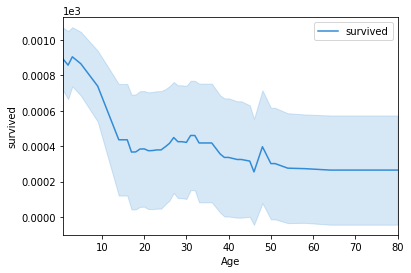

In [69]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))